# Lecture : Graph Transformers & Graph ViT

## Lab 02 : Graph Transformers (GT with Positional Encoding) -- Solution

### Xavier Bresson

Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020   
https://arxiv.org/pdf/2012.09699.pdf


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/10_Graph_Transformers'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL


In [2]:
# Libraries
import dgl
from dgl.data import MiniGCDataset
import dgl.function as fn
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_ncut


# Visualize the artifical graph dataset used in this notebook

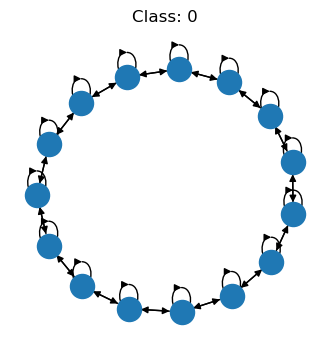

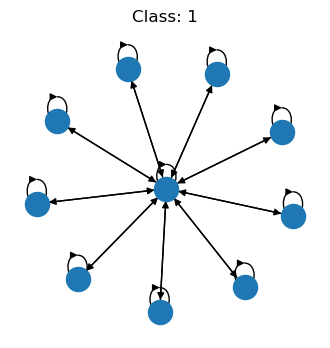

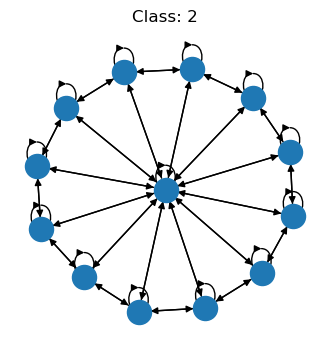

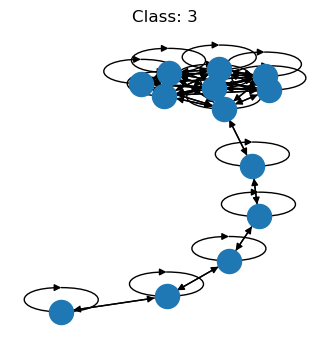

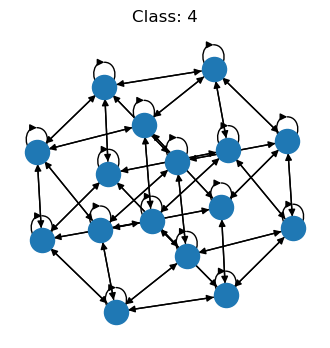

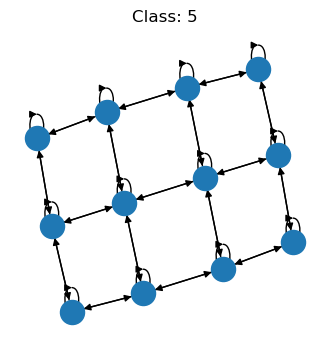

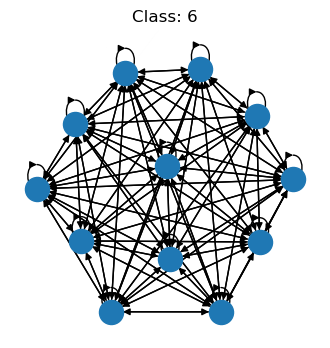

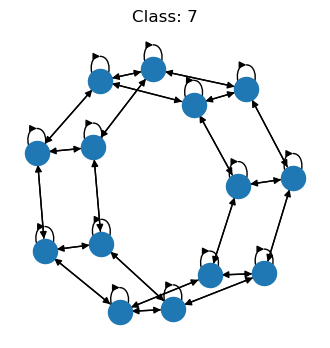

In [3]:
dataset = MiniGCDataset(8, 10, 20) # DGL artificial dataset

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = dataset[c]
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(4,4))
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Exercise 1: Generate train, val and test datasets



### Question 1.1: Use Laplacian eigenvectors as positional encoding

**Instructions:**

- *Step 1:* Compute the (normalized) Laplacian operator: $L = I - D^{-1/2}AD^{-1/2}$. You may use ```g.adj().to_dense(), g.in_degree(), torch.eye()``` for computing the adjacency matrix $A$, node degree matrix $D$, and the identity matrix $I$, respectively.

- *Step 2:* Compute the eigenvectors and eigenvalues of the Laplacian operator using eigenvalue decomposition (EVD): ```torch.linalgeig()```.

- *Step 3:* Convert the eigenvectors and eigenvalues into real values, e.g., ```X_real = X.real```. (Think of when a matrix has all real-values eigenvalues and eigenvectors and when it doesn't)

- *Step 4:* Sort the Eigenvectors in increasing order of eigenvalues, ```X_sorted = X[:, Y.argsort()]```.

- *Step 5:* Select the first non-trivial "pos_enc_dim" eigenvector.

In [4]:
# Laplacian eigenvectors as positional encoding
def LapEig_positional_encoding(g, pos_enc_dim):
    ###############################################
    # YOUR CODE STARTS
    ###############################################
    # Step 1
    # Compute the Adjacency matrix
    Adj = g.adj().to_dense()
    # Inverse and sqrt of degree matrix
    Dn = ( g.in_degrees()** -0.5 ).diag()
    # Compute Laplacian operator
    Lap = torch.eye(g.number_of_nodes()) - Dn.matmul(Adj).matmul(Dn)

    # Step 2
    # Compute full EVD of Lap
    EigVal, EigVec = torch.linalg.eig(Lap)

    # Step 3
    # Make eig real
    EigVal, EigVec = EigVal.real, EigVec.real

    # Step 4
    # sort in increasing order of eigenvalues
    EigVec = EigVec[:, EigVal.argsort()]

    # Step 5
    # select the first non-trivial "pos_enc_dim" eigenvector
    EigVec = EigVec[:,1:pos_enc_dim+1]
    ###############################################
    # YOUR CODE ENDS
    ###############################################

    return EigVec

### Question 1.2: Add node features and node postional encoding features to graphs

**Instructions:**

- Assign node features to graphs by storing node in-degrees in the ```ndata``` dictionary with the key ```'feat'```: ```g.ndata['feat']```.

- Assign node positional encoding features to graphs by storing these features in the ```ndata``` dictionary with the key ```'pos_enc'```: ```g.ndata['pos_enc']```.


In [5]:
# Add node and positional encoding features to graphs
pos_enc_dim = 2 # dimension of PE
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Assign Laplacian eigenvectors as positional encoding features to graphs
        graph.ndata['pos_enc'] = LapEig_positional_encoding(graph, pos_enc_dim)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

    return dataset

### Generate graph datasets

In [6]:
# Generate graph datasets
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
valset = add_node_edge_features(valset)
print(trainset[0])


(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'pos_enc': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), tensor(0))


### Visualize positional encoding

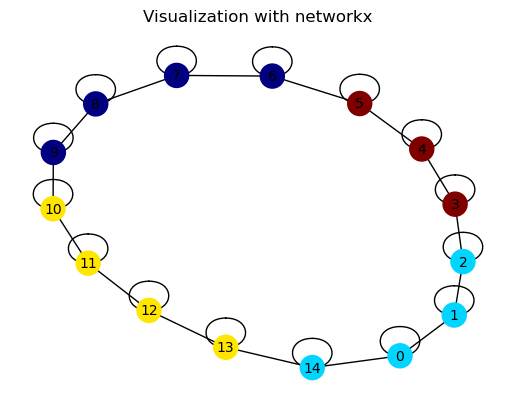

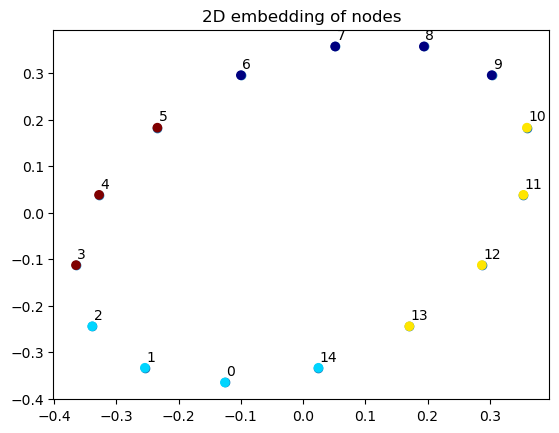

In [7]:
graph = trainset[0][0]

# Visualize graph
fig = plt.figure()
ax = fig.add_subplot(111)
Adj = graph.adj().to_dense()
A_nx = nx.from_numpy_array(Adj.numpy())
C = compute_ncut(Adj.long(), 4)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Visualization with networkx')
plt.show()

# plot 2D coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
x = graph.ndata['pos_enc']
ax.scatter(x[:,0], x[:,1])
idx = list(range(graph.number_of_nodes()))
ax.scatter(x[:,0], x[:,1], c=C, cmap='jet')
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embedding of nodes')
plt.show()


### Define the collate function to prepare a batch of DGL graphs and test it like the previous exercise

In [8]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels (here class label)
    return batch_graphs, batch_labels


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_pe = batch_graphs.ndata['pos_enc']
print('batch_pe:',batch_pe.size())


Graph(num_nodes=120, num_edges=1012,
      ndata_schemes={'pos_enc': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})
tensor([4, 4, 3, 2, 4, 6, 7, 3, 7, 7])
batch_pe: torch.Size([120, 2])


# Exercise 2: Design the class of GraphTransformer networks (with positional encoding)

Node update equation:
\begin{eqnarray*}
\bar{h}^{\ell} &=&  h^{\ell} + \textrm{gMHA} (\textrm{LN}(h^{\ell})) \in \mathbb{R}^{N\times d}\\
h^{\ell+1} &=& \bar{h}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{h}^{\ell})) \in \mathbb{R}^{N\times d}\\
&&\textrm{with } \textrm{gMHA}(h)=\textrm{Concat}_{k=1}^H \left( \textrm{gHA}(h_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, W_O\in \mathbb{R}^{d\times d} \\
&&\quad\quad\ \textrm{gHA}(h)=\textrm{Softmax}\left( A_G \odot \frac{QK^T}{\sqrt{d'}} \right) V \in \mathbb{R}^{N\times d'=d/H}, A_G\in \mathbb{R}^{N\times N} \textrm{ (graph adjacency matrix)}\\
&&\quad\quad\ \textrm{gHA}(h)_i= \sum_{j\in \mathcal{N}_i} \underbrace{\frac{\exp(q_i^T k_j/\sqrt{d'})}{ \sum_{j'\in\mathcal{N}_i} \exp(q_i^T k_{j'}/\sqrt{d'}) }}_{\textrm{graph attention score}_{ij}} v_j\ \textrm{ (point-wise equation)}\\
&&\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d'=d/H}, W_Q, W_K, W_V\in \mathbb{R}^{d'\times d'}\\
h^{\ell=0} &=& \textrm{LL}_1(h_0)+\textrm{LL}_2(p_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature and positional encoding)}\\
&&\textrm{with } p_0=\Phi_{\{2,..,K+1\}}\in \mathbb{R}^{N\times K},\ \Delta = \Phi \Lambda \Phi^T \in \mathbb{R}^{N\times N}
\end{eqnarray*}


### Implement a MLP layer for classification like the previous exercise

In [9]:
# class MLP layer for classification
class MLP_layer(nn.Module):

    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L

    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y



### Implement a Graph Multi-Head Attention (MHA) Layer with DGL like the previous exercise

In [10]:
# class graph multi head attention layer
class graph_MHA_layer(nn.Module): # MHA = Multi Head Attention

    def __init__(self, hidden_dim, head_hidden_dim, num_heads): # hidden_dim = d
        super().__init__()
        self.head_hidden_dim = head_hidden_dim # head_hidden_dim = d' = d/K
        self.num_heads = num_heads # number of heads = K
        self.WQ = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True) # define K x WQ matrix of size=(d',d')
        self.WK = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WV = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)

    # Step 1 of message-passing with DGL:
    #   Node feature and edge features are passed along edges (src/j => dst/i)
    def message_func(self, edges):
        # Step 1.1: Compute q_i^T * k_j, size=(E,K,1), edges.src/dst[].size=(E,K,d')
        qikj = (edges.src['K'] * edges.dst['Q']).sum(dim=2).unsqueeze(2)

        # Step 1.2: Compute exp_ij = exp( q_i^T * k_j / sqrt(d') ), size=(E,K,1)
        expij = torch.exp( qikj / torch.sqrt(torch.tensor(self.head_hidden_dim)) )

        # Step 1.3: Obtain V
        vj = edges.src['V'] # size=(E,K,d')

        return {'expij' : expij, 'vj' : vj}

    # Step 2 of message-passing with DGL:
    #   Reduce function collects all messages={hj, eij} sent to node dst/i with Step 1
    #                   and sum/mean over the graph neigbors j in Ni
    def reduce_func(self, nodes):
        # Step 2.1: Collects all messages= eij
        # size=(N,|Nj|,K,1), |Nj|=num_neighbors
        expij = nodes.mailbox['expij']

        # Step 2.1: Collects all messages= vj
        # size=(N,|Nj|,K,d')
        vj = nodes.mailbox['vj']

        # Step 2.2: Sum/mean over the graph neigbors j in Ni
        # sum_j exp_ij . v_j, size=(N,K,d')
        numerator = torch.sum( expij * vj, dim=1 )

        # sum_j' exp_ij', size=(N,K,1)
        denominator = torch.sum( expij, dim=1 )

        # h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij', size=(N,K,d')
        h = numerator / denominator

        return {'h' : h}

    def forward(self, g, h):
        Q = self.WQ(h) # size=(N, d)
                       # computational trick to compute quickly K linear transformations h_k.WQ of size=(N, d')
                       # first compute linear transformation h.WQ of size=(N, d)
                       # then reshape h.WQ of size=(N, K, d'=d/K)
        K = self.WK(h) # size=(N, d)
        V = self.WV(h) # size=(N, d)
        g.ndata['Q'] = Q.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['K'] = K.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['V'] = V.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.update_all(self.message_func, self.reduce_func) # compute with DGL the graph MHA
        gMHA = g.ndata['h'] # size=(N, K, d'=d/K)
        return gMHA




### Implement a GraphTransformer layer like the previous exercise

In [11]:
# class GraphTransformer layer
class GraphTransformer_layer(nn.Module):

    def __init__(self, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim # hidden_dim = d
        self.num_heads = num_heads # number of heads = K
        self.dropout_mha = nn.Dropout(dropout) # dropout value
        self.dropout_mlp = nn.Dropout(dropout) # dropout value
        self.gMHA = graph_MHA_layer(hidden_dim, hidden_dim//num_heads, num_heads) # graph MHA layer
        self.WO = nn.Linear(hidden_dim, hidden_dim) # LL
        self.layer_norm1 = nn.LayerNorm(hidden_dim) # layer normalization
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP

    def forward(self, g, h):

        # Self-attention layer
        h_rc = h # size=(N,d), V=num_nodes, for residual connection
        h = self.layer_norm1(h) # layer normalization, size=(N, d)
        h_MHA = self.gMHA(g, h) # MHA, size=(N, K, d'=d/K)
        h_MHA = h_MHA.view(-1, self.hidden_dim) # size=(N, d)
        h_MHA = self.dropout_mha(h_MHA) # dropout, size=(N, d)
        h_MHA = self.WO(h_MHA) # LL, size=(N, d)
        h = h_rc + h_MHA # residual connection, size=(N, d)

        # Fully-connected layer
        h_rc = h # for residual connection, size=(N, d)
        h = self.layer_norm2(h) # layer normalization, size=(N, d)
        h_MLP = self.linear1(h) # LL, size=(H, d)
        h_MLP = torch.relu(h_MLP) # size=(N, d)
        h_MLP = self.dropout_mlp(h_MLP) # dropout, size=(N, d)
        h_MLP = self.linear2(h_MLP) # LL, size=(N, d)
        h = h_rc + h_MLP # residual connection, size=(N, d)

        return h




### Question 2.1: Combine all previous defined MLP Layer, GraphTransformer layer to construct the Graph Transformer network (with positional encoding)

**Instructions:**

<!-- - *Input embedding layer:* Initialize a linear layer $LL_1(h_0)$ to convert input features $h_0$ into node embeddings and another linear layer $LL_2(p_0)$ to convert input positional encoding features $p_0$ into positional encoding embeddings. Summing up by $h^{\ell=0} = \textrm{LL}_1(h_0)+\textrm{LL}_2(p_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature and positional encoding)}$ -->
- *Input embedding layer:* Initialize a linear layer ```nn.Linear()``` to convert input positional encoding features into node positional encoding embeddings.

In [12]:
# class Graph Transformer network
class GraphTransformer_net(nn.Module):

    def __init__(self, net_parameters):
        super(GraphTransformer_net, self).__init__()
        input_dim = net_parameters['input_dim']
        pos_enc_dim = net_parameters['pos_enc_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        num_heads = net_parameters['num_heads']
        L = net_parameters['L']

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        self.embedding_pe = nn.Linear(pos_enc_dim, hidden_dim)
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        # self.embedding_e = nn.Linear(1, hidden_dim)
        self.GraphTransformer_layers = nn.ModuleList([ GraphTransformer_layer(hidden_dim, num_heads) for _ in range(L) ])
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)

    def forward(self, g, pe):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # input node embedding = positional embedding
        # Compute the linear transformation of the positional embedding
        # You may use "nn.Linear(pos_enc_dim, hidden_dim)"
        h = self.embedding_pe(pe) # size=(num_nodes, hidden_dim)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        # graph convnet layers
        for GT_layer in self.GraphTransformer_layers:
            h = GT_layer(g,h) # size=(num_nodes, hidden_dim)

        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors, size=(num_graphs, hidden_dim)
        y = self.MLP_layer(y) # size=(num_graphs, num_classes)
        return y




### Question 2.2: Instantiate a graph Transformer network (with pisitional encoding)

In [13]:
# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['num_heads'] = 8
net_parameters['norm'] = 'BN'
net_parameters['L'] = 4
net = GraphTransformer_net(net_parameters)
print(net)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]

###############################################
# YOUR CODE STARTS
###############################################
batch_pe = batch_graphs.ndata['pos_enc']
###############################################
# YOUR CODE ENDS
###############################################

batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_pe)
print(batch_scores.size())


GraphTransformer_net(
  (embedding_pe): Linear(in_features=2, out_features=128, bias=True)
  (GraphTransformer_layers): ModuleList(
    (0-3): 4 x GraphTransformer_layer(
      (dropout_mha): Dropout(p=0.0, inplace=False)
      (dropout_mlp): Dropout(p=0.0, inplace=False)
      (gMHA): graph_MHA_layer(
        (WQ): Linear(in_features=128, out_features=128, bias=True)
        (WK): Linear(in_features=128, out_features=128, bias=True)
        (WV): Linear(in_features=128, out_features=128, bias=True)
      )
      (WO): Linear(in_features=128, out_features=128, bias=True)
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=Tru

/Users/xbresson/miniconda3/envs/gnn_course/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


# Train the network

In [14]:
def accuracy(scores, targets):
    scores = scores.detach().argmax(dim=1)
    acc = (scores==targets).float().sum().item()
    return acc

def run_one_epoch(net, data_loader, train=True, loss_fc=None, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_pe = batch_graphs.ndata['pos_enc']
        batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_pe)
        loss = loss_fc(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc, optimizer


# dataset loaders
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
del net
net = GraphTransformer_net(net_parameters)
_ = display_num_param(net)

# optimizer
loss_fc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)

# training loop
start = time.time()
for epoch in range(50):
    epoch_train_loss, epoch_train_acc, optimizer = run_one_epoch(net, train_loader, True, loss_fc, optimizer)
    with torch.no_grad():
        epoch_test_loss, epoch_test_acc, _ = run_one_epoch(net, test_loader, False, loss_fc)
        epoch_val_loss, epoch_val_acc, _ = run_one_epoch(net, val_loader, False, loss_fc)
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
    print('                       train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc, epoch_val_acc))


Number of parameters: 432776 (0.43 million)
Epoch 0, time 5.0446, train_loss: 2.0898, test_loss: 2.0736, val_loss: 2.0734
                       train_acc: 0.1200, test_acc: 0.1600, val_acc: 0.1600
Epoch 1, time 6.4932, train_loss: 2.0798, test_loss: 2.0691, val_loss: 2.0692
                       train_acc: 0.1457, test_acc: 0.2800, val_acc: 0.2800
Epoch 2, time 7.7352, train_loss: 2.0702, test_loss: 2.0585, val_loss: 2.0587
                       train_acc: 0.1771, test_acc: 0.1900, val_acc: 0.1900
Epoch 3, time 12.1876, train_loss: 2.0522, test_loss: 2.0187, val_loss: 2.0217
                       train_acc: 0.2429, test_acc: 0.4000, val_acc: 0.3900
Epoch 4, time 13.4848, train_loss: 1.9919, test_loss: 1.9303, val_loss: 1.9202
                       train_acc: 0.3629, test_acc: 0.3900, val_acc: 0.3800
Epoch 5, time 14.4792, train_loss: 1.8577, test_loss: 1.7294, val_loss: 1.7246
                       train_acc: 0.2914, test_acc: 0.3000, val_acc: 0.3100
Epoch 6, time 15.5252, train_

## Compare results

| GNN    | train acc | test acc |
| -------- | ------- | ------- |
| GCN  | 0.7829   | 0.7900    |
| GIN | 0.0800     | 0.1000     |
| GAT    | 0.9229    | 0.9400    |
| Vanilla GT    | 0.9229    | 0.9400    |
| GT (w/ PE)    | 1.0000    | 1.0000    |
